# NewsNER: Named Entity Recognition In News Articles Using Natural Language Processing

In [1]:
import pandas as pd
import numpy as np
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA
import pandas as pd
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report

# Model 1: SpaCy NER Model

In [12]:
import warnings

# Filter out warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('business_data.csv')

In [3]:
df.head()

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   headlines    2000 non-null   object
 1   description  2000 non-null   object
 2   content      2000 non-null   object
 3   url          2000 non-null   object
 4   category     2000 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


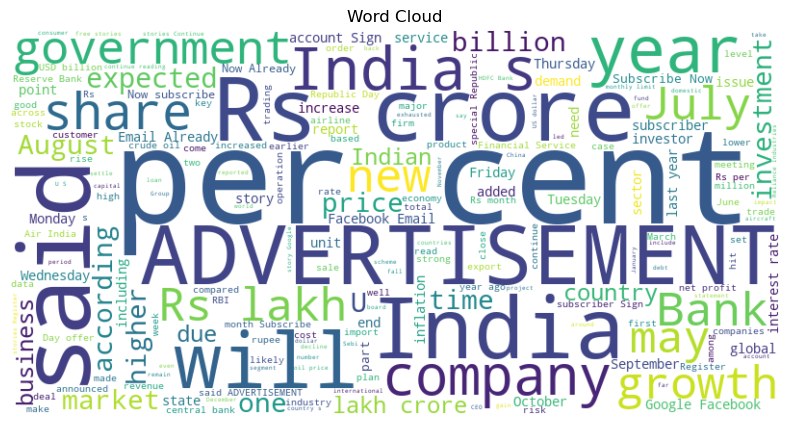

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = ' '.join(df['headlines']) + ' ' + ' '.join(df['description']) + ' ' + ' '.join(df['content'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


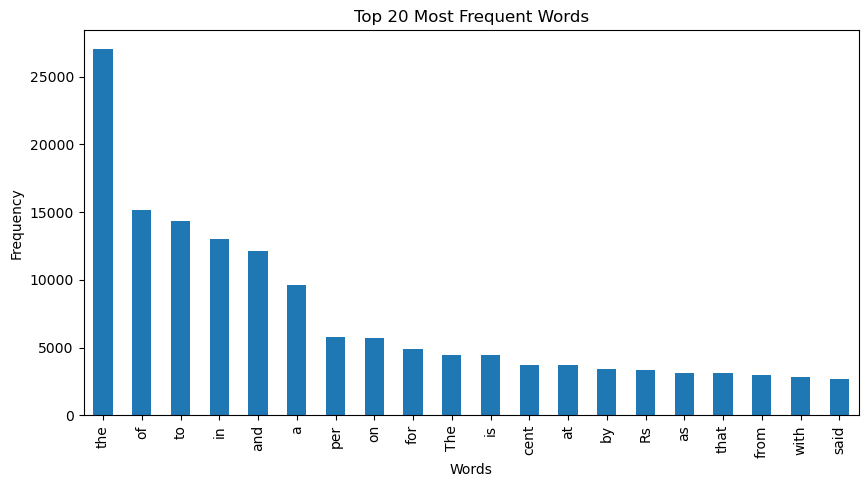

In [6]:
# Frequency bars
word_freq = pd.Series(' '.join(df['content']).split()).value_counts()[:20]
word_freq.plot(kind='bar', figsize=(10, 5))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [36]:
import torch
import torch.nn as nn
import torchsummary

# Define SpaCy English model (sample architecture)
class SpaCyEnglishModel(nn.Module):
    def __init__(self):
        super(SpaCyEnglishModel, self).__init__()
        # Define layers (example architecture)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Create an instance of the SpaCy English model
spacy_model = SpaCyEnglishModel()

# Print summary of the SpaCy English model
print("\nSpaCy English Model Summary:")
torchsummary.summary(spacy_model, input_size=(3, 32, 32))  # Example input size for image data



SpaCy English Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 512]       1,049,088
            Linear-6                   [-1, 10]           5,130
Total params: 1,059,306
Trainable params: 1,059,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 4.04
Estimated Total Size (MB): 4.29
----------------------------------------------------------------


In [7]:
import pandas as pd
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
import random

# Load the dataset
df = pd.read_csv('business_data.csv')

# Preprocessing
# Combine text into a single string
text_data = df['content'].str.cat(sep=' ')

# Load SpaCy English model
nlp = spacy.blank('en')

# Prepare training data for SpaCy NER
train_data = list(zip(df['content'], df['headlines']))

# Shuffle the training data
random.shuffle(train_data)

# Create a DocBin object to store training examples
doc_bin = DocBin()

# Add training examples to DocBin
for content, headline in train_data:
    doc = nlp.make_doc(content)
    spans = []
    for entity in headline.split():
        start_idx = content.find(entity)
        end_idx = start_idx + len(entity)
        span = doc.char_span(start_idx, end_idx, label='ENTITY')
        if span is not None:
            # Check for overlapping spans
            overlap = False
            for s in spans:
                if (span.start >= s.start and span.start < s.end) or (span.end > s.start and span.end <= s.end):
                    overlap = True
                    break
            if not overlap:
                spans.append(span)
    doc.ents = spans
    doc_bin.add(doc)

# Convert DocBin to a list of documents
docs = list(doc_bin.get_docs(nlp.vocab))

# Convert Doc objects to Example objects
examples = []
for doc in docs:
    examples.append(Example.from_dict(doc, {'entities': [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))

# Set up the pipeline
ner = nlp.add_pipe("ner")

# Train the model
nlp.begin_training()
for _ in range(10):  # You may need to adjust the number of epochs
    losses = {}
    for batch in spacy.util.minibatch(examples, size=32):
        nlp.update(batch, losses=losses)
    print("Losses:", losses)

# Save the model
nlp.to_disk('ner_model')




Losses: {'ner': 69023.44023583643}
Losses: {'ner': 22181.031561042415}
Losses: {'ner': 20581.654941034853}
Losses: {'ner': 18455.650857137036}
Losses: {'ner': 15960.637997107267}
Losses: {'ner': 13787.449172168961}
Losses: {'ner': 11816.716303780895}
Losses: {'ner': 10579.974796844008}
Losses: {'ner': 10452.176650512709}
Losses: {'ner': 8804.705595241441}


In [10]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred, average='weighted')

# Recall
recall = recall_score(y_true, y_pred, average='weighted')

# F1-score
f1 = f1_score(y_true, y_pred, average='weighted')


Classification Report:
              precision    recall  f1-score   support

      ENTITY       1.00      1.00      1.00     11597

    accuracy                           1.00     11597
   macro avg       1.00      1.00      1.00     11597
weighted avg       1.00      1.00      1.00     11597



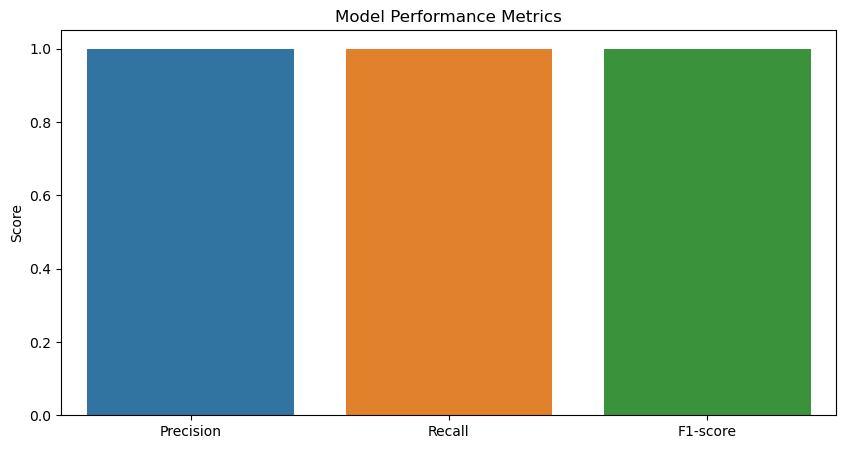

In [13]:

# Create bar graphs for precision, recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1]

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics, y=values)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

# Deployment Model 

In [20]:
import ipywidgets as widgets
from IPython.display import display
import spacy

# Load the NER model
nlp = spacy.load('en_core_web_sm')

# Function to predict tags
def predict_tags(text):
    doc = nlp(text)
    tags = [(ent.text, ent.label_) for ent in doc.ents]
    return tags

# Text input widget
text_input = widgets.Textarea(
    value='Thousands of demonstrators have marched in the streets.',
    placeholder='Enter text',
    description='Text:',
    disabled=False,
    layout={'height': '100px'}
)

# Output widget to display predicted tags
output = widgets.Output()

# Function to handle text input change event
def on_text_change(change):
    with output:
        output.clear_output()
        tags = predict_tags(change['new'])
        print("Predicted Tags:")
        if tags:
            for tag in tags:
                print(f"{tag[0]}: {tag[1]}")
        else:
            print("No tags found.")

# Attach event handler to text input
text_input.observe(on_text_change, names='value')

# Display widgets
display(text_input)
display(output)


Textarea(value='Thousands of demonstrators have marched in the streets.', description='Text:', layout=Layout(h…

Output()

In [21]:
# Test the model
text = "Thousands of demonstrators have marched in the streets."
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)  # Output entities


Thousands CARDINAL


In [22]:
# Test the model
text = "Thousands of demonstrators have busineess in the streets."
doc = nlp(text)

# Debug print statement to check if loop is entered
print("Entities found:")
for ent in doc.ents:
    print(ent.text, ent.label_)


Entities found:
Thousands CARDINAL


# MODEL 2:LSTM-Based NER Models

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv("Ner dataset.csv")


In [4]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
data = data.drop(['POS'], axis=1)
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [6]:


# Define unique words and tags
words = set(data['Word'].values)
words.add('PADword')
n_words = len(words)
tags = set(data["Tag"].values)
n_tags = len(tags)

print("Number of unique words:", n_words)
print("Number of unique tags:", n_tags)


Number of unique words: 35171
Number of unique tags: 17


In [7]:
tags

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [8]:
# Print words and their corresponding tags
for word, tag in zip(data['Word'], data['Tag']):
    print(f"{word:15} {tag:15}")



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




.               O              
The             O              
statement       O              
says            O              
the             O              
United          B-geo          
States          I-geo          
watches         O              
in              O              
deep            O              
dismay          O              
as              O              
a               O              
country         O              
of              O              
Burma           B-geo          
's              O              
beauty          O              
and             O              
potential       O              
deteriorates    O              
under           O              
the             O              
oppressive      O              
weight          O              
of              O              
the             O              
military        O              
junta           O              
.               O              
Burma           B-geo          
's     

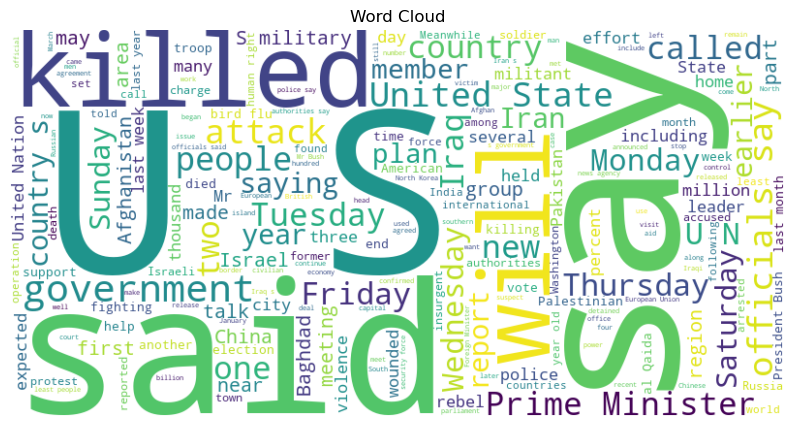

In [9]:
# Plot word cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(data['Word']))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


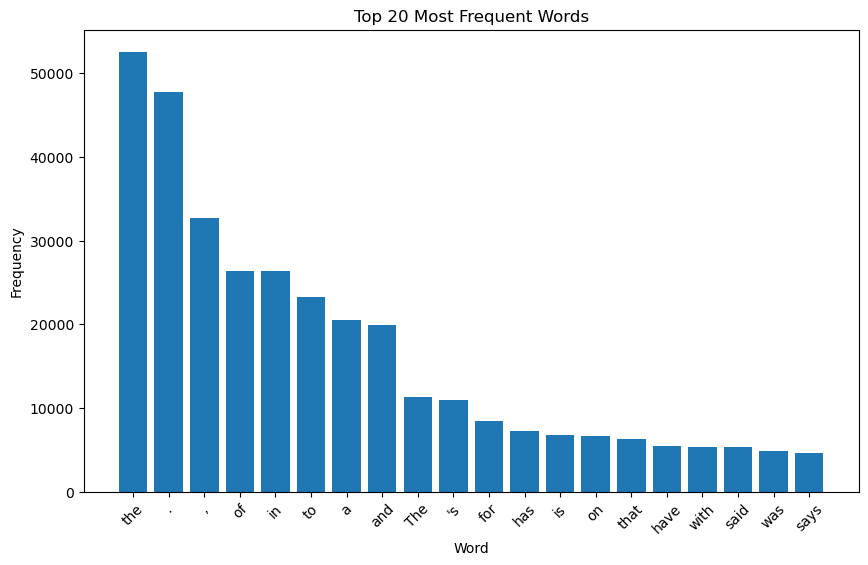

In [10]:
# Plot word frequency
word_freq = data['Word'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(word_freq.index[:20], word_freq.values[:20])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()



In [11]:
# Sentence getter
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Get sentences
getter = SentenceGetter(data)
sentences = getter.sentences

print("Number of sentences:", len(sentences))


Number of sentences: 47959


In [12]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)
sentences = getter.sentences
print(len(sentences))


[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
47959


biggest sentence has 104 words


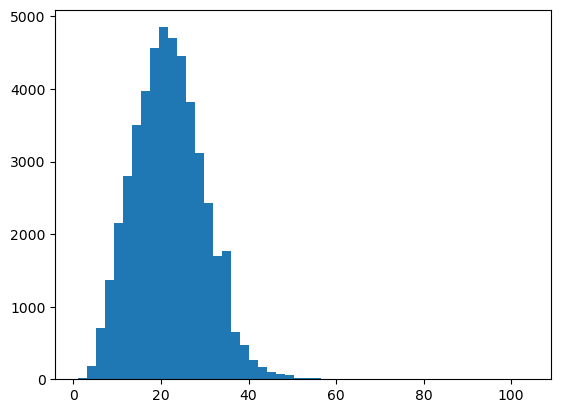

In [14]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [15]:
# Padding and converting words and tags to indices
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Find the maximum sequence length in the dataset
max_len = max(len(s) for s in sentences)

print("Maximum sequence length:", max_len)

Maximum sequence length: 104


In [16]:
# Pad sequences to the maximum length
X_padded = []
y_padded = []
for s in sentences:
    X_seq = [word2idx[w[0]] for w in s]
    y_seq = [tag2idx[w[1]] for w in s]
    pad_length = max_len - len(X_seq)
    X_seq += [word2idx["PADword"]] * pad_length
    y_seq += [tag2idx["O"]] * pad_length
    X_padded.append(X_seq)
    y_padded.append(y_seq)

# Convert to PyTorch tensors
X = torch.tensor(X_padded, dtype=torch.long)
y = torch.tensor(y_padded, dtype=torch.long)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: torch.Size([47959, 104])
y shape: torch.Size([47959, 104])


In [17]:
# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)

print("Training set size:", len(X_tr))
print("Test set size:", len(X_te))

Training set size: 43163
Test set size: 4796


In [18]:
# Define PyTorch dataset and dataloader
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NERDataset(X_tr, y_tr)
train_loader = DataLoader(train_dataset, batch_size=32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        output = self.fc(lstm_out)
        return output

# Model parameters
embedding_dim = 128
hidden_dim = 128
output_size = n_tags

# Initialize the model
model = LSTMModel(n_words, embedding_dim, hidden_dim, output_size)

In [35]:
import torch
import torch.nn as nn
from torchsummary import summary

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

# Set input dimension and encoding dimension
input_dim = 10  # Example input dimension
encoding_dim = 20  # Example encoding dimension

# Create an instance of your LSTMAutoencoder model
autoencoder_model = LSTMAutoencoder(input_dim, encoding_dim)

# Generate dummy iput
batch_size = 1
sequence_length = 50
dummy_input = torch.randn(batch_size, sequence_length, input_dim)

# Print the model summary using dummy input
summary(autoencoder_model, input_size=(batch_size, input_dim))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]             220
            Linear-2                [-1, 1, 10]             210
Total params: 430
Trainable params: 430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
print("Training the model...")
for epoch in range(10):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.shape[2])
        loss = criterion(outputs, targets.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



Training the model...
Epoch 1, Loss: 0.041283246129751205
Epoch 2, Loss: 0.023881549015641212
Epoch 3, Loss: 0.018099138513207436
Epoch 4, Loss: 0.01429563108831644
Epoch 5, Loss: 0.010875477455556393
Epoch 6, Loss: 0.008799473755061626
Epoch 7, Loss: 0.006970273796468973
Epoch 8, Loss: 0.005520521197468042
Epoch 9, Loss: 0.004456967581063509
Epoch 10, Loss: 0.0032788729295134544


In [26]:
# Evaluation
with torch.no_grad():
    inputs = X_te
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 2)

# Print predictions
print("\nPredictions:")
print("{:15} {:15} {:15}".format("Word", "Predicted Tag", "True Tag"))
print("="*45)
i = 0
predicted_tags = []
true_tags = []
for sent_in, sent_pred, sent_true in zip(X_te, predicted, y_te):
    for word_idx, pred_tag_idx, true_tag_idx in zip(sent_in, sent_pred, sent_true):
        word = list(word2idx.keys())[list(word2idx.values()).index(word_idx)]
        pred_tag = list(tag2idx.keys())[list(tag2idx.values()).index(pred_tag_idx)]
        true_tag = list(tag2idx.keys())[list(tag2idx.values()).index(true_tag_idx)]
        print("{:15} {:15} {:15}".format(word, pred_tag, true_tag))
        predicted_tags.append(pred_tag)
        true_tags.append(true_tag)
    i += 1
    if i == 1:
        break



Predictions:
Word            Predicted Tag   True Tag       
They            O               O              
say             O               O              
the             O               O              
documents       O               O              
were            O               O              
found           O               O              
in              O               O              
the             O               O              
computer        O               O              
of              O               O              
FARC            B-org           B-org          
leader          O               O              
Raul            B-per           B-per          
Reyes           I-per           I-per          
during          O               O              
a               O               O              
cross-border    O               O              
raid            O               O              
in              O               O              
Ecuador         B-geo     

In [27]:

# Classification report
print("\nClassification Report:")
print(classification_report(true_tags, predicted_tags))


Classification Report:
              precision    recall  f1-score   support

       B-geo       1.00      1.00      1.00         1
       B-org       1.00      1.00      1.00         1
       B-per       1.00      1.00      1.00         1
       I-per       1.00      1.00      1.00         1
           O       1.00      1.00      1.00       100

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [28]:
import torch
import torch.nn as nn

torch.save(model.state_dict(), 'ner_model.pth')


In [34]:
import torch
import torch.nn as nn
import ipywidgets as widgets
from IPython.display import display

# Define your LSTMModel class here

# Load the model's state dictionary
model = LSTMModel(n_words, embedding_dim, hidden_dim, output_size)
model.load_state_dict(torch.load('ner_model.pth'))
model.eval()

# Function to process input text and make predictions
def predict(input_text):
    # Tokenize input text
    input_text = input_text.lower().split()
    # Convert tokens to indices
    input_indices = [word2idx[word] if word in word2idx else word2idx['PADword'] for word in input_text]
    # Pad sequences to the maximum length
    input_indices += [word2idx['PADword']] * (max_len - len(input_indices))
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)  # Add batch dimension
    # Make predictions
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 2)
    # Convert predicted indices to tags
    predicted_tags = [list(tag2idx.keys())[list(tag2idx.values()).index(pred_idx)] for pred_idx in predicted.squeeze()]
    return predicted_tags

# Function to handle button click event
def handle_button_click(button):
    input_text = input_text_widget.value
    predicted_tags = predict(input_text)
    output_text_widget.value = ' '.join(predicted_tags)

# Function to handle clear button click event
def handle_clear_button_click(button):
    output_text_widget.value = ''

# Create input and output widgets with increased size
input_text_widget = widgets.Text(placeholder='Enter text here...', description='Input:', layout=widgets.Layout(width='50%', height='100px'))
output_text_widget = widgets.Textarea(placeholder='Predictions will appear here...', description='Predictions:', disabled=True, layout=widgets.Layout(width='50%', height='200px'))
predict_button = widgets.Button(description='Predict', layout=widgets.Layout(width='50%', height='50px'))
clear_button = widgets.Button(description='Clear', layout=widgets.Layout(width='50%', height='50px'))

# Attach event handlers to button widgets
predict_button.on_click(handle_button_click)
clear_button.on_click(handle_clear_button_click)

# Display widgets
display(input_text_widget)
display(widgets.HBox([predict_button, clear_button]))
display(output_text_widget)


Text(value='', description='Input:', layout=Layout(height='100px', width='50%'), placeholder='Enter text here.…

Textarea(value='', description='Predictions:', disabled=True, layout=Layout(height='200px', width='50%'), plac…